In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FactorAnalysis
from scipy.stats import linregress
from sklearn.model_selection import KFold

from pytorch_stats_model_multi_dim import * 

import glob, h5py
from tqdm import tqdm
from sklearn.metrics import r2_score 
import pickle

from scipy.optimize import least_squares

In [2]:
#%% 
import os, math
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import norm
from scipy.stats import vonmises

os.chdir('e:\\Python\\molanalysis')

from loaddata.get_data_folder import get_local_drive

from scipy.stats import vonmises
from utils.explorefigs import plot_PCA_gratings
from loaddata.session import Session
from utils.corr_lib import *
from loaddata.session_info import filter_sessions,load_sessions
from utils.psth import compute_respmat
from utils.tuning import compute_tuning, compute_prefori
from utils.plotting_style import * #get all the fixed color schemes

In [3]:
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False, 'axes.labelcolor': '0', 'text.color':'0', 'xtick.color':'0', 'ytick.color':'0'}),

SMALL_SIZE = 12
MEDIUM_SIZE = 21
BIGGER_SIZE = 21

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
data_file = sorted(glob.glob('./dataset/dataset1/*.mat'))
f = h5py.File(data_file[4],'r')
ref_spikes = f['spikes']
ref_stim = f['stim']
V1_spks = np.array(f[ref_spikes[0,0]]) #3200 trials x 1280 ms x n1
V2_spks = np.array(f[ref_spikes[1,0]]) #3200 trials x 1280 ms x n2
stim = np.array(f.get('/stim')) # 1x3200 trials

n_trial, T, n1 = V1_spks.shape
junk, junk, n2 = V2_spks.shape
n_stim = int(np.max(stim))
print(n1, n2)

#bin the data
bin_width = 100
n_bin = int(T/bin_width)
V1_spks_binned = np.reshape(V1_spks[:, :n_bin*bin_width, :], (n_trial, bin_width, n_bin, n1), order='F')
V1_spks_binned = np.sum(V1_spks_binned, 1)

V2_spks_binned = np.reshape(V2_spks[:, :n_bin*bin_width, :], (n_trial, bin_width, n_bin, n2), order='F')
V2_spks_binned = np.sum(V2_spks_binned, 1)

stim_order = np.argsort(stim[0,:])
V1_spks_binned = V1_spks_binned[stim_order,:,:]
V1_tmp = np.mean(V1_spks_binned[:400, :, :],0)
neuron_order = np.argsort(np.max(V1_tmp,0)) #order neuron based on their peak responses during orientaton 0

V2_spks_binned = V2_spks_binned[stim_order,:,:]
V2_tmp = np.mean(V2_spks_binned[:400, :, :],0)
neuron_order2 = np.argsort(np.max(V2_tmp,0))


V1_tuning = np.zeros((n1,n_stim))
V2_tuning = np.zeros((n2,n_stim))
for stim_i in range(n_stim):
    V1_tuning[:, stim_i] = np.mean(V1_spks_binned[400*stim_i: 400*(stim_i+1),int(100/bin_width):,:],(0,1)) # (n1,)
    V2_tuning[:, stim_i] = np.mean(V2_spks_binned[400*stim_i: 400*(stim_i+1),int(100/bin_width):,:],(0,1)) # (n2,)


V1_f = np.sum(V1_spks_binned[:,int(100/bin_width):,:],1).T
V2_f = np.sum(V2_spks_binned[:,int(100/bin_width):,:],1).T


IndexError: list index out of range

In [5]:
#%% #############################################################################
session_list        = np.array([['LPE10919','2023_11_06']])
# session_list        = np.array([['LPE10885','2023_10_23']])
# session_list        = np.array([['LPE12223','2024_06_10']])

# load sessions lazy: 
sessions,nSessions   = load_sessions(protocol = 'GR',session_list=session_list)

#   Load proper data and compute average trial responses:                      
for ises in range(nSessions):    # iterate over sessions
    sessions[ises].load_respmat(load_behaviordata=True, load_calciumdata=True,load_videodata=True,
                                calciumversion='deconv',keepraw=True)
                                # calciumversion='dF',keepraw=True)

In [6]:
R                       = sessions[ises].respmat

V1_f                    = R[sessions[ises].celldata['roi_name']=='V1',:].T
V2_f                    = R[sessions[ises].celldata['roi_name']=='PM',:].T

n_trial, n1 = V1_f.shape
junk,  n2 = V2_f.shape
print(n1, n2)

ustim,junk,stim          = np.unique(sessions[ises].trialdata['Orientation'],return_index=True,return_inverse=True)
n_stim = len(ustim)

V1_tuning = np.zeros((n1,n_stim))
V2_tuning = np.zeros((n2,n_stim))
for istim in range(n_stim):
    # V1_tuning[:, stim_i] = np.mean(V1_spks_binned[400*stim_i: 400*(stim_i+1),int(100/bin_width):,:],(0,1)) # (n1,)
    # V2_tuning[:, stim_i] = np.mean(V2_spks_binned[400*stim_i: 400*(stim_i+1),int(100/bin_width):,:],(0,1)) # (n2,)
    V1_tuning[:, istim] = np.mean(V1_f[stim==istim,:],axis=0) # (n1,)
    V2_tuning[:, istim] = np.mean(V2_f[stim==istim,:],axis=0) # (n2,)

V1_f                    = V1_f.T
V2_f                    = V2_f.T


1643 1622


In [7]:
def soft_cluster(f):
    # cluster based on score of maximum absolute value
    cluster_ids = np.argmax(np.abs(f), axis=1)
    scores = f[range(f.shape[0]), cluster_ids]

    # resort within each cluster
    perm = []
    for cluster in np.unique(cluster_ids):
        idx = np.where(cluster_ids == cluster)[0]
        perm += list(idx[np.argsort(scores[idx])][::-1])
    return cluster_ids, perm

#exclude silent neurons
if (V1_tuning==0).any():
    id_silent = np.unique(np.where(V1_tuning==0)[0])
    print(id_silent)
    V1_f = np.delete(V1_f, id_silent, axis=0)
    V1_tuning = np.delete(V1_tuning, id_silent, axis=0)
    n1 -= id_silent.shape[0]
    print(V1_f.shape)

if (V2_tuning==0).any():
    id_silent = np.unique(np.where(V2_tuning==0)[0])
    print(id_silent)
    V2_f = np.delete(V2_f, id_silent, axis=0)
    V2_tuning = np.delete(V2_tuning, id_silent, axis=0)
    n2 -= id_silent.shape[0]
    print(V2_f.shape)

pref_ori_V1, tuning_order_V1 = soft_cluster(V1_tuning)
pref_ori_V2, tuning_order_V2 = soft_cluster(V2_tuning)

n1,n2

(1643, 1622)

In [8]:
def calculate_OTI_direct(V1_tuning):
    
    tuning = V1_tuning
    max_tuning = np.max(tuning,1)
    min_tuning = np.min(tuning,1)

    OTI = (max_tuning-min_tuning)/(max_tuning+min_tuning)
    return OTI

In [9]:
OTI_V1_direct = calculate_OTI_direct(V1_tuning)
OTI_V2_direct = calculate_OTI_direct(V2_tuning)

In [10]:
thr = 0.35
print(len(np.where(OTI_V1_direct>thr)[0]))
print(len(np.where(OTI_V2_direct>thr)[0]))


1218
1038


In [11]:
n1 = np.sum(OTI_V1_direct>thr)
n2 = np.sum(OTI_V2_direct>thr)

V1_f_new = V1_f[OTI_V1_direct>thr, :]
V2_f_new = V2_f[OTI_V2_direct>thr, :]

V1_f= V1_f_new
V2_f= V2_f_new

V1_tuning = V1_tuning[OTI_V1_direct>0.35,:]
V2_tuning = V2_tuning[OTI_V2_direct>0.35,:]

pref_ori_V1, tuning_order_V1 = soft_cluster(V1_tuning)
pref_ori_V2, tuning_order_V2 = soft_cluster(V2_tuning)

In [12]:
n_trial = 200
n_trial_train = 160
n_trial_test = 40

V1_f_ = V1_f.reshape((n1, n_trial, n_stim), order='F')
V2_f_ = V2_f.reshape((n2, n_trial, n_stim), order='F')



In [13]:
V1_f_
np.shape(V1_f_)

(1218, 200, 16)

## Fit statistical models

In [21]:
aff_model_V1_all = [] # affine model fit to V1 data
mul_model_V1_all = [] # multiplicative model fit to V1 data
add_varp_model_V1_all = [] # additive model fit to V1 data
gen_model_V1_all = [] # generalized model fit to V1 data
add_model_V1_all = [] # This is NOT the additive model used in Xia et al 2023, this additive model assumes stimulus-independent private variability
expo_model_V1_all = [] # This model is not used in Xia et al 2023

# same set of statistical models fit to V2 data
aff_model_V2_all = []
mul_model_V2_all = []
add_varp_model_V2_all = []
gen_model_V2_all = []
add_model_V2_all = []
expo_model_V2_all = []

# index of trials in 5-fold cross-validation
train_ind_all = []
test_ind_all = []

kf = KFold(n_splits=5,shuffle=True)
split=0

for train_ind, test_ind in tqdm(kf.split(np.arange(n_trial))):        
    split += 1
    
    V1_f_train = V1_f_[:,train_ind,:].reshape((n1, -1), order='F')
    V1_f_test = V1_f_[:,test_ind,:].reshape((n1, -1), order='F')
    
    V2_f_train = V2_f_[:,train_ind,:].reshape((n2, -1), order='F')
    V2_f_test = V2_f_[:,test_ind,:].reshape((n2, -1), order='F')
    
    x1 = V1_f_train.reshape(n1, -1, order='F')
    x_test1 = V1_f_test.reshape(n1, -1, order='F')
    
    x2 = V2_f_train.reshape(n2, -1, order='F')
    x_test2 = V2_f_test.reshape(n2, -1, order='F')

    train_ind_all.append(train_ind)
    test_ind_all.append(test_ind)
    
    for n_compo in range(1,2):
        # gen_model_V1 = generalized_model(x1, n1, n_stim, n_trial_train, x_test1, n_trial_test, n_compo)
        # add_model_V1 = additive_model(x1, n1, n_stim, n_trial_train, x_test1, n_trial_test, n_compo)

        # gen_model_V1_all.append(gen_model_V1)
        # add_model_V1_all.append(add_model_V1)
        
        #############
        print('mul model')
        psi_p_init =   np.zeros((n1, n_compo))
        alpha_p_init =  np.zeros((n1, n_compo))
        
        mul_model_V1 = multiplicative_model(x1, n1, n_stim, n_trial_train, n_compo, alpha_p_init, psi_p_init)
        # junk = mul_model_V1.train(5e-3, x1, n_trial_train)
        mul_model_V1_all.append(mul_model_V1)
        
        # ##########
        # psi_p_init = aff_model_V2.psi_p.detach().numpy().copy()
        # alpha_p_init = aff_model_V2.alpha_p.detach().numpy().copy()
        
        # mul_model_V2 = multiplicative_model(x2, n2, n_stim, n_trial_train, n_compo, alpha_p_init, psi_p_init)
        # junk = mul_model_V2.train(5e-3, x2, n_trial_train)
        # mul_model_V2_all.append(mul_model_V2)

        # #########
        # gen_model_V2 = generalized_model(x2, n2, n_stim, n_trial_train, x_test2, n_trial_test, n_compo)
        # add_model_V2 = additive_model(x2, n2, n_stim, n_trial_train, x_test2, n_trial_test, n_compo)

        # gen_model_V2_all.append(gen_model_V2)
        # add_model_V2_all.append(add_model_V2)
        
        
        # ########
        # beta_p_init = add_model_V1.h_p.copy()
        # psi_p_init = gen_model_V1.psi_p.copy()
        # expo_p_init = 0.5
        
        # expo_model_V1 = exponent_model(x1, n1, n_stim, n_trial_train, n_compo, expo_p_init, beta_p_init, psi_p_init)
        # junk = expo_model_V1.train(1e-2, x1, n_trial_train)
        
        # expo_model_V1_all.append(expo_model_V1)
        # ########
        
        # beta_p_init = add_model_V2.h_p.copy()
        # psi_p_init = gen_model_V2.psi_p.copy()
        # expo_p_init = 0.5
        
        # expo_model_V2 = exponent_model(x2, n2, n_stim, n_trial_train, n_compo, expo_p_init, beta_p_init, psi_p_init)
        # junk = expo_model_V2.train(1e-2, x2, n_trial_train)
        
        # expo_model_V2_all.append(expo_model_V2)
        
        
        # #########
        # h_p_init = add_model_V1.h_p.copy()
        # psi_p_init = gen_model_V1.psi_p.copy()

        # add_varp_model_V1 = additive_varp_model(x1, n1, n_stim, n_trial_train, n_compo, h_p_init, psi_p_init)
        # d_add_varp_V1, h_add_varp_V1, psi_add_varp_V1 = add_varp_model_V1.train(1e-2, x1, n_trial_train)

        # add_varp_model_V1_all.append(add_varp_model_V1) 
        
        # ###################################
        # h_p_init = add_model_V2.h_p.copy()
        # psi_p_init = gen_model_V2.psi_p.copy()

        # add_varp_model_V2 = additive_varp_model(x2, n2, n_stim, n_trial_train, n_compo, h_p_init, psi_p_init)
        # d_add_varp_V2, h_add_varp_V2, psi_add_varp_V2 = add_varp_model_V2.train(1e-2, x2, n_trial_train)

        # add_varp_model_V2_all.append(add_varp_model_V2) 
        
        
        # # ##############
        # alpha_p_init = np.zeros((n1, n_compo))
        # beta_p_init = add_model_V1.h_p.copy()
        # psi_p_init = gen_model_V1.psi_p.copy()

        # aff_model_V1 = affine_model(x1, n1, n_stim, n_trial_train, n_compo, alpha_p_init, beta_p_init, psi_p_init)
        # d_aff_V1, alpha_aff_V1, beta_aff_V1, psi_aff_V1 = aff_model_V1.train(1e-2, x1, n_trial_train)

        # aff_model_V1_all.append(aff_model_V1)
        
        
        # ##############
        # alpha_p_init = np.zeros((n2, n_compo))
        # beta_p_init = add_model_V2.h_p.copy()
        # psi_p_init = gen_model_V2.psi_p.copy()

        # aff_model_V2 = affine_model(x2, n2, n_stim, n_trial_train, n_compo, alpha_p_init, beta_p_init, psi_p_init)
        # d_aff_V2, alpha_aff_V2, beta_aff_V2, psi_aff_V2 = aff_model_V2.train(1e-2, x2, n_trial_train)

        # aff_model_V2_all.append(aff_model_V2)
        
        # #############
        # print('mul model')
        # psi_p_init = aff_model_V1.psi_p.detach().numpy().copy()
        # alpha_p_init = aff_model_V1.alpha_p.detach().numpy().copy()
        
        # mul_model_V1 = multiplicative_model(x1, n1, n_stim, n_trial_train, n_compo, alpha_p_init, psi_p_init)
        # junk = mul_model_V1.train(5e-3, x1, n_trial_train)
        # mul_model_V1_all.append(mul_model_V1)
        
        # ##########
        # psi_p_init = aff_model_V2.psi_p.detach().numpy().copy()
        # alpha_p_init = aff_model_V2.alpha_p.detach().numpy().copy()
        
        # mul_model_V2 = multiplicative_model(x2, n2, n_stim, n_trial_train, n_compo, alpha_p_init, psi_p_init)
        # junk = mul_model_V2.train(5e-3, x2, n_trial_train)
        # mul_model_V2_all.append(mul_model_V2)
        
        

0it [00:00, ?it/s]

2it [00:00,  5.85it/s]

mul model
mul model


4it [00:00,  6.77it/s]

mul model
mul model


5it [00:00,  6.35it/s]

mul model


In [ ]:
dir(mul_model_V1)
mul_model_V1.recon_data


<bound method multiplicative_model.recon_data of <pytorch_stats_model_multi_dim.multiplicative_model object at 0x000002372EF4E5B0>>

In [15]:
x1 = V1_f.reshape(n1, -1, order='F')
x_test1 = V1_f.reshape(n1, -1, order='F')

gen_model_V1 = generalized_model(x1, n1, n_stim, n_trial, x_test1, n_trial, 5)
# add_model_V1 = additive_model(x1, n1, n_stim, n_trial, x_test1, n_trial, 1)

gen_model_V1.x_recon
np.shape(gen_model_V1.x_recon)


test NLL:  6316.515541172847 train NLL:  6316.515541172847


(1218, 3200)

(633, 2560)

In [16]:
n_compo = 2

x1 = V1_f.reshape(n1, -1, order='F')
x_test1 = V1_f.reshape(n1, -1, order='F')

print('mul model')
psi_p_init =   np.zeros((n1, n_stim))
alpha_p_init =  np.zeros((n1, n_compo))

mul_model_V1 = multiplicative_model(x1, n1, n_stim, n_trial, n_compo, alpha_p_init, psi_p_init)
# junk = mul_model_V1.train(5e-3, x1, n_trial_train)
mul_model_V1_all.append(mul_model_V1)

mul_model_V1.x_recon,g = mul_model_V1.recon_data(x1,n_trial)

mul model


In [17]:
# x1 = V1_f.reshape(n1, -1, order='F')
# x_test1 = V1_f.reshape(n1, -1, order='F')
n_compo = 1

add_model_V1 = additive_model(x1, n1, n_stim, n_trial, x_test1, n_trial, n_compo)

add_model_V1.x_recon
np.shape(add_model_V1.x_recon)

test NLL:  6641.168878100268 train NLL:  6641.168878100268


(1218, 3200)

In [ ]:
# sessions[ises].respmat = R
# sessions[ises].respmat = add_model_V1.x_recon
# sessions[ises].respmat = gen_model_V1.x_recon
# sessions[ises].respmat = mul_model_V1.x_recon.detach().numpy()
# mul_model_V1
fig = plot_PCA_gratings(sessions[ises])


AttributeError: 'multiplicative_model' object has no attribute 'x_recon'

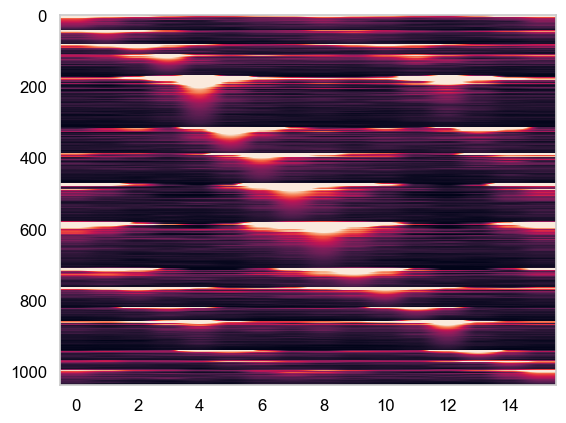

In [20]:
plt.imshow(V1_tuning[tuning_order_V1,:],aspect='auto',vmin=np.percentile(V1_tuning,5),vmax=np.percentile(V1_tuning,95))
plt.imshow(V2_tuning[tuning_order_V2,:],aspect='auto',vmin=np.percentile(V2_tuning,5),vmax=np.percentile(V2_tuning,95))



In [61]:
# with open('write_your_own_path.pkl', 'wb') as file:
#     pickle.dump([train_ind_all, test_ind_all,
#                  expo_model_V1_all, expo_model_V2_all,
#                  mul_model_V1_all, mul_model_V2_all,
#                  aff_model_V1_all, aff_model_V2_all,  
#                  add_varp_model_V1_all, add_varp_model_V2_all,
#                  gen_model_V1_all, gen_model_V2_all,
#                  add_model_V1_all, add_model_V2_all], file)

## Load trained models

In [16]:
with open('./stats_model_fitting_res/stats_model_res/dataset4_multidim_5_fold_cv_OTI_035.pkl', 'rb') as fp:
        [train_ind_all, test_ind_all,
         expo_model_V1_all, expo_model_V2_all,
         mul_model_V1_all, mul_model_V2_all,
         aff_model_V1_all, aff_model_V2_all,  
         add_varp_model_V1_all, add_varp_model_V2_all,
         gen_model_V1_all, gen_model_V2_all,
         add_model_V1_all, add_model_V2_all] = pickle.load(fp)

## Plot fitting performances (log-likelihood) of statistical models

In [17]:
def plot_LL(x, x_test, add_model, add_varp_model, mul_model, aff_model, expo_model, gen_model):
    ll_add = -add_model.NLL
    ll_add_test = -add_model.NLL_test

    ll_add_varp = -add_varp_model.loss_nll(x, n_trial_train)
    ll_add_varp_test = -add_varp_model.loss_nll(x_test, n_trial_test)

    ll_mul = -mul_model.loss_nll(x, n_trial_train)
    ll_mul_test = -mul_model.loss_nll(x_test, n_trial_test)
    
    ll_aff = -aff_model.loss_nll(x, n_trial_train)
    ll_aff_test = -aff_model.loss_nll(x_test, n_trial_test)
    
    ll_expo = -expo_model.loss_nll(x, n_trial_train)
    ll_expo_test = -expo_model.loss_nll(x_test, n_trial_test)
    
    ll_gen = -gen_model.NLL
    ll_gen_test = -gen_model.NLL_test

    ll_train = [ll_add, ll_add_varp.detach().numpy(), ll_mul.detach().numpy(), ll_aff.detach().numpy(), ll_expo.detach().numpy(), ll_gen]
    ll_test = [ll_add_test, ll_add_varp_test.detach().numpy(), ll_mul_test.detach().numpy(), ll_aff_test.detach().numpy(), ll_expo_test.detach().numpy(), ll_gen_test]

    return ll_train, ll_test

In [18]:
stats_model_list = [add_varp_model_V1_all, mul_model_V1_all, aff_model_V1_all, expo_model_V1_all,
                    add_varp_model_V2_all, mul_model_V2_all, aff_model_V2_all, expo_model_V2_all]
for stats_model in stats_model_list:
    for model in stats_model:
        model.SMALL = 1e-5

In [19]:
n_compo_len = 5
n_fold = 5

ll_train1_all = np.zeros((6, n_compo_len, n_fold))
ll_test1_all = np.zeros((6, n_compo_len, n_fold))

ll_train2_all = np.zeros((6, n_compo_len, n_fold))
ll_test2_all = np.zeros((6, n_compo_len, n_fold))

colors = plt.cm.inferno(np.linspace(0,0.9,n_compo_len))


# plot for different component
for i in range(n_compo_len):
    for j in range(n_fold):
        
        train_ind = train_ind_all[j]
        test_ind = test_ind_all[j]

        V1_f_train = V1_f_[:,train_ind,:].reshape((n1, -1), order='F')
        V1_f_test = V1_f_[:,test_ind,:].reshape((n1, -1), order='F')

        V2_f_train = V2_f_[:,train_ind,:].reshape((n2, -1), order='F')
        V2_f_test = V2_f_[:,test_ind,:].reshape((n2, -1), order='F')

        x1 = V1_f_train.reshape(n1, -1, order='F')
        x_test1 = V1_f_test.reshape(n1, -1, order='F')

        x2 = V2_f_train.reshape(n2, -1, order='F')
        x_test2 = V2_f_test.reshape(n2, -1, order='F')

        
        add_model_V1 = add_model_V1_all[i+j*n_compo_len]
        add_varp_model_V1 = add_varp_model_V1_all[i+j*n_compo_len]
        mul_model_V1 = mul_model_V1_all[i+j*n_compo_len]
        aff_model_V1 = aff_model_V1_all[i+j*n_compo_len]
        gen_model_V1 = gen_model_V1_all[i+j*n_compo_len]
        expo_model_V1 = expo_model_V1_all[i+j*n_compo_len]

        
        add_model_V2 = add_model_V2_all[i+j*n_compo_len]
        add_varp_model_V2 = add_varp_model_V2_all[i+j*n_compo_len]
        mul_model_V2 = mul_model_V2_all[i+j*n_compo_len]
        aff_model_V2 = aff_model_V2_all[i+j*n_compo_len]
        gen_model_V2 = gen_model_V2_all[i+j*n_compo_len]
        expo_model_V2 = expo_model_V2_all[i+j*n_compo_len]


        ll_train1, ll_test1 = plot_LL(x1, x_test1, add_model_V1, add_varp_model_V1, mul_model_V1, aff_model_V1, expo_model_V1, gen_model_V1)

        ll_train1_all[:,i,j] = ll_train1
        ll_test1_all[:,i,j] = ll_test1
        
        ll_train2, ll_test2 = plot_LL(x2, x_test2, add_model_V2, add_varp_model_V2, mul_model_V2, aff_model_V2, expo_model_V2, gen_model_V2)

        ll_train2_all[:,i,j] = ll_train2
        ll_test2_all[:,i,j] = ll_test2


In [20]:
fig,ax = plt.subplots(1,2, figsize=(8,3))
for i in range(n_compo_len):
    ax[0].errorbar(np.arange(6), np.mean(ll_train1_all[:,i,:],1),np.std(ll_train1_all[:,i,:],1)/np.sqrt(n_fold),linestyle='--', color=colors[i])
    ax[0].errorbar(np.arange(6), np.mean(ll_test1_all[:,i,:],1),np.std(ll_test1_all[:,i,:],1)/np.sqrt(n_fold), color=colors[i])
    
    ax[1].errorbar(np.arange(6), np.mean(ll_train2_all[:,i,:],1),np.std(ll_train2_all[:,i,:],1)/np.sqrt(n_fold),linestyle='--', color=colors[i])
    ax[1].errorbar(np.arange(6), np.mean(ll_test2_all[:,i,:],1),np.std(ll_test2_all[:,i,:],1)/np.sqrt(n_fold), color=colors[i], label='%d compo'%(i+1))
    

ax[0].set_title('V1')
ax[1].set_title('V2')

plt.sca(ax[0])
plt.xticks([0,1,2,3,4,5], ['add*', 'add', 'mul', 'aff','expo', 'gen'])
plt.ylabel('LL')
plt.xlabel('Model')


plt.sca(ax[1])
plt.xticks([0,1,2,3,4,5], ['add*', 'add', 'mul', 'aff','expo', 'gen'])
plt.ylabel('LL')
plt.xlabel('Model')
plt.legend()


# Shrink current axis by 20%
box = ax[1].get_position()
ax[1].set_position([box.x0, box.y0, box.width * 1, box.height])

# Put a legend to the right of the current axis
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


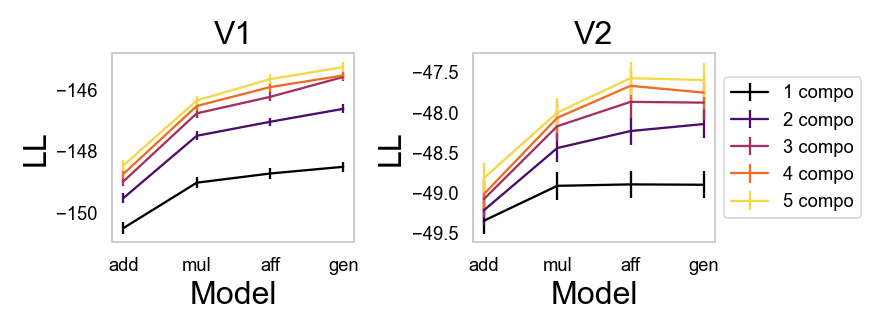

In [106]:
model_ls = [1,2,3,5]

fig,ax = plt.subplots(1,2, figsize=(8,3))
for i in range(n_compo_len):
    #ax[0].errorbar(np.arange(4), np.mean(ll_train1_all[model_ls,i,:],1),np.std(ll_train1_all[model_ls,i,:],1)/np.sqrt(n_fold),linestyle='--', color=colors[i])
    ax[0].errorbar(np.arange(4), np.mean(ll_test1_all[model_ls,i,:],1),np.std(ll_test1_all[model_ls,i,:],1)/np.sqrt(n_fold), color=colors[i])
    
    #ax[1].errorbar(np.arange(4), np.mean(ll_train2_all[model_ls,i,:],1),np.std(ll_train2_all[model_ls,i,:],1)/np.sqrt(n_fold),linestyle='--', color=colors[i])
    ax[1].errorbar(np.arange(4), np.mean(ll_test2_all[model_ls,i,:],1),np.std(ll_test2_all[model_ls,i,:],1)/np.sqrt(n_fold), color=colors[i], label='%d compo'%(i+1))
    

ax[0].set_title('V1')
ax[1].set_title('V2')

plt.sca(ax[0])
plt.xticks([0,1,2,3], [ 'add', 'mul', 'aff','gen'])
plt.ylabel('LL',fontsize=MEDIUM_SIZE)
plt.xlabel('Model',fontsize=MEDIUM_SIZE)


plt.sca(ax[1])
plt.xticks([0,1,2,3], ['add', 'mul', 'aff','gen'])
plt.ylabel('LL',fontsize=MEDIUM_SIZE)
plt.xlabel('Model',fontsize=MEDIUM_SIZE)
plt.legend()


# Shrink current axis by 20%
box = ax[1].get_position()
ax[1].set_position([box.x0, box.y0, box.width * 1, box.height])

# Put a legend to the right of the current axis
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
#plt.savefig('2023_fig/utah_array_stats_model/dataset1_only_test_LL.pdf', transparent=True)

## Plot fitting performance ($R^2$ of noise covariance) of statistical models

In [21]:
def calculate_nc(V1_f,n1, n_trial, n_stim=8):
    #calculate noise covariance 
    V1_spks_res = np.zeros((n_trial*n_stim, n1)) 
    for stim_i in range(n_stim):
        trial_avg = np.mean(V1_f[:, n_trial*stim_i: n_trial*(stim_i+1)],1)
        V1_spks_res[n_trial*stim_i: n_trial*(stim_i+1),:] = (V1_f[:,n_trial*stim_i: n_trial*(stim_i+1)] - trial_avg[:,np.newaxis]).T

    ncov_V1 = np.zeros((n1, n1, n_stim)) 
    
    ## plot nc with axis centered around neurons' whose pref ori match with the input
    for stim_i0 in range(n_stim):
        ncov_V1[:,:, stim_i0] = np.cov(V1_spks_res[n_trial*stim_i0: n_trial*(stim_i0 + 1), :].T)

    return ncov_V1

def calculate_r2_nc(ncov_V1, ncov_V1_add, n1, n_stim=8):
    #ncov from data
    x1 = np.zeros((int(n1*(n1-1)/2), n_stim))
    
    #ncov from model
    x2 = np.zeros((int(n1*(n1-1)/2), n_stim))
    
    for stim_i in range(n_stim):
        tmp = ncov_V1[:,:, stim_i]
        x1[:, stim_i] = tmp[np.triu_indices(n1, 1)]
        
        tmp = ncov_V1_add[:,:, stim_i]
        x2[:, stim_i] = tmp[np.triu_indices(n1, 1)]
        
    r2 = r2_score(x1, x2)
    return r2

In [22]:
def calculate_ncov_from_phi(phi):
    #phi is n x n_compo x n_stim 
    ncov = np.einsum('ijk, ljk->ilk', phi, phi)
    return ncov

def calculate_phi_from_model(add_model, add_varp_model, mul_model, aff_model, expo_model,gen_model,  n_stim=8):
    phi_add = np.tile(add_model.h_p[:,:, None], (1,1,n_stim))
    
    phi_add_varp = np.tile(add_varp_model.h_p[:,:,None].detach().numpy(), (1,1,n_stim))
    
    phi_mul_tmp = mul_model.alpha_p[:,:,None]*mul_model.d_p[:,None,:]
    phi_mul = phi_mul_tmp.detach().numpy()
    
    phi_aff_tmp = aff_model.alpha_p[:,:,None]*aff_model.d_p[:,None,:]+aff_model.beta_p[:,:,None]
    phi_aff = phi_aff_tmp.detach().numpy()
    
    phi_gen = gen_model.F_p
    
    phi_expo_tmp = expo_model.alpha_p[:,:,None]*(expo_model.d_p[:,None,:]**expo_model.expo_p)+expo_model.beta_p[:,:,None]
    phi_expo = phi_expo_tmp.detach().numpy()
    
    return phi_add, phi_add_varp, phi_mul, phi_aff, phi_expo, phi_gen

In [23]:
r2_nc_V1_all = np.zeros((6, n_compo_len, n_fold))
r2_nc_V2_all = np.zeros((6, n_compo_len, n_fold))

for j in range(n_fold):

    train_ind = train_ind_all[j]
    test_ind = test_ind_all[j]

    V1_f_train = V1_f_[:,train_ind,:].reshape((n1, -1), order='F')
    V1_f_test = V1_f_[:,test_ind,:].reshape((n1, -1), order='F')

    V2_f_train = V2_f_[:,train_ind,:].reshape((n2, -1), order='F')
    V2_f_test = V2_f_[:,test_ind,:].reshape((n2, -1), order='F')

    x1 = V1_f_train.reshape(n1, -1, order='F')
    x_test1 = V1_f_test.reshape(n1, -1, order='F')

    x2 = V2_f_train.reshape(n2, -1, order='F')
    x_test2 = V2_f_test.reshape(n2, -1, order='F')
    
    for i in range(n_compo_len):
        add_model_V1 = add_model_V1_all[i+j*n_compo_len]
        add_varp_model_V1 = add_varp_model_V1_all[i+j*n_compo_len]
        mul_model_V1 = mul_model_V1_all[i+j*n_compo_len]
        aff_model_V1 = aff_model_V1_all[i+j*n_compo_len]
        gen_model_V1 = gen_model_V1_all[i+j*n_compo_len]
        expo_model_V1 = expo_model_V1_all[i+j*n_compo_len]

        add_model_V2 = add_model_V2_all[i+j*n_compo_len]
        add_varp_model_V2 = add_varp_model_V2_all[i+j*n_compo_len]
        mul_model_V2 = mul_model_V2_all[i+j*n_compo_len]
        aff_model_V2 = aff_model_V2_all[i+j*n_compo_len]
        gen_model_V2 = gen_model_V2_all[i+j*n_compo_len]
        expo_model_V2 = expo_model_V2_all[i+j*n_compo_len]

        ncov_V1= calculate_nc(x_test1, n1, n_trial_test, n_stim)
        ncov_V2= calculate_nc(x_test2, n2, n_trial_test, n_stim)
        
        phi_V1 = calculate_phi_from_model(add_model_V1, add_varp_model_V1, mul_model_V1, aff_model_V1, expo_model_V1, gen_model_V1, n_stim=8)
        phi_V2 = calculate_phi_from_model(add_model_V2, add_varp_model_V2, mul_model_V2, aff_model_V2, expo_model_V2, gen_model_V2, n_stim=8)
        
        ncov_from_phi_V1 = [np.zeros((n1,n1,n_stim))]*6
        ncov_from_phi_V2 = [np.zeros((n2,n2,n_stim))]*6
        
        for model_i, phi in enumerate(phi_V1):
            ncov_from_phi_V1[model_i] = calculate_ncov_from_phi(phi)
            
        for model_i, phi in enumerate(phi_V2):
            ncov_from_phi_V2[model_i] = calculate_ncov_from_phi(phi)
        
        #plot r2 for ncov_V1
        ncov_V1_models = ncov_from_phi_V1
        ncov_V2_models = ncov_from_phi_V2
        
        
        r2_nc_V1 = []
        r2_nc_V2 = []        
        
        for ncov_V1_model, ncov_V2_model in zip(ncov_V1_models, ncov_V2_models):

            r2_model = calculate_r2_nc(ncov_V1, ncov_V1_model, n1, n_stim)
            r2_nc_V1.append(r2_model)
            
            r2_model = calculate_r2_nc(ncov_V2, ncov_V2_model, n2, n_stim)
            r2_nc_V2.append(r2_model)
            
        r2_nc_V1_all[:,i,j] = r2_nc_V1
        r2_nc_V2_all[:,i,j] = r2_nc_V2
        
        

In [24]:
fig, ax = plt.subplots(1,2,figsize=(7,2.5))

for i in range(n_compo_len):
    ax[0].errorbar(range(6), np.mean(r2_nc_V1_all[:,i,:],1),np.std(r2_nc_V1_all[:,i,:],1)/np.sqrt(n_fold) , c = colors[i])
    ax[1].errorbar(range(6), np.mean(r2_nc_V2_all[:,i,:],1),np.std(r2_nc_V2_all[:,i,:],1)/np.sqrt(n_fold) , c = colors[i], label='%d ')
    
model_label=['add*', 'add','mul', 'aff', 'expo','gen']

plt.sca(ax[0])
plt.xticks(range(len(model_label)), model_label)
plt.ylabel('$R^2$')
plt.xlabel('models')
plt.title('V1 ncov')

plt.sca(ax[1])
plt.xticks(range(len(model_label)), model_label)
plt.ylabel('$R^2$')
plt.xlabel('models')
plt.title('V2 ncov')


plt.tight_layout()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


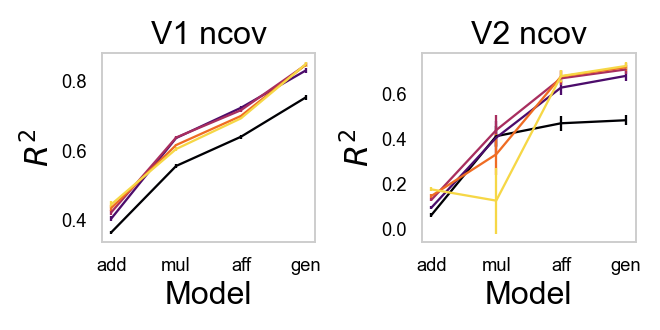

In [109]:
fig, ax = plt.subplots(1,2,figsize=(6,3))

for i in range(n_compo_len):
    ax[0].errorbar(range(4), np.mean(r2_nc_V1_all[model_ls,i,:],1),np.std(r2_nc_V1_all[model_ls,i,:],1)/np.sqrt(n_fold) , c = colors[i])
    ax[1].errorbar(range(4), np.mean(r2_nc_V2_all[model_ls,i,:],1),np.std(r2_nc_V2_all[model_ls,i,:],1)/np.sqrt(n_fold) , c = colors[i], label='%d ')
    
model_label1=['add','mul', 'aff', 'gen']

plt.sca(ax[0])
plt.xticks(range(len(model_label1)), model_label1)
plt.ylabel('$R^2$',fontsize=MEDIUM_SIZE)
plt.xlabel('Model',fontsize=MEDIUM_SIZE)
plt.title('V1 ncov')

plt.sca(ax[1])
plt.xticks(range(len(model_label1)), model_label1)
plt.ylabel('$R^2$',fontsize=MEDIUM_SIZE)
plt.xlabel('Model',fontsize=MEDIUM_SIZE)
plt.title('V2 ncov')


plt.tight_layout()
#plt.savefig('2023_fig/utah_array_stats_model/dataset3_R2.pdf', transparent=True)

## Visualize the amplitude of shared variability $\phi$ from the fitted statistical models

In [25]:
## visualize phi and d
def plot_shared_noise_coef(d, phi_V1, tuning_order):
    n = len(tuning_order)
    
    
    plt.figure(figsize=(10,3))
    ax1 = plt.subplot(151)
    plt.imshow(d[tuning_order,:], aspect='auto', cmap='viridis')#, vmin=0, vmax=np.max(gen_model.d_p))
    plt.title('Trial-avg',fontsize=MEDIUM_SIZE)
    plt.ylabel('Neuron',fontsize=MEDIUM_SIZE)
    plt.xlabel('Stim',fontsize=MEDIUM_SIZE)
    plt.yticks([0, n-1],[1,n])
    plt.xticks(range(8),[1] + [" "]*6 + [8])
    ax1.tick_params(bottom=True)
    cbar = plt.colorbar()
    
    bbox = cbar.ax.get_position()
    plt.text(bbox.x0 + bbox.width / 2, 1.02, '(Hz)', transform=cbar.ax.transAxes, va='bottom', ha='left')

    
    comp_ind=0

    F_p = phi_V1[5][:,comp_ind,:]
    for stim_i in range(n_stim):
    # unify the sign of F_p across stimuli. 
        if stim_i ==0:
            ref_F = F_p[:,0]
        else:
            sign = (np.sum(ref_F * F_p[:, stim_i]) > np.sum(-ref_F * F_p[:, stim_i]))
            if not sign:
                F_p[:, stim_i] *= -1

    if np.sum(ref_F)<0:
        F_p = F_p*-1

    ax5 = plt.subplot(155)
    plt.title(model_label[5],fontsize=MEDIUM_SIZE)
    plt.xlabel('Stim',fontsize=MEDIUM_SIZE)
    plt.xticks(range(8),[1] + [" "]*6 + [8])
    plt.yticks([0],[' '])
    ax5.tick_params(bottom=True)
    plt.imshow(F_p[tuning_order,:], aspect='auto', vmin=np.min(F_p), vmax=np.max(F_p))
    plt.colorbar()

    ax3 = plt.subplot(153)
    plt.imshow(phi_V1[2][tuning_order,0,:], aspect='auto', vmin=np.min(F_p), vmax=np.max(F_p))
    plt.title(model_label[2],fontsize=MEDIUM_SIZE)
    plt.xlabel('Stim',fontsize=MEDIUM_SIZE)
    plt.xticks(range(8),[1] + [" "]*6 + [8])
    plt.yticks([])
    plt.colorbar()
    ax3.tick_params(bottom=True)
    
    ax4 = plt.subplot(154)
    plt.imshow(phi_V1[3][tuning_order,0,:], aspect='auto', vmin=np.min(F_p), vmax=np.max(F_p))
    plt.title(model_label[3],fontsize=MEDIUM_SIZE)
    plt.xlabel('Stim',fontsize=MEDIUM_SIZE)
    plt.xticks(range(8),[1] + [" "]*6 + [8])
    plt.yticks([])
    plt.colorbar()
    ax4.tick_params(bottom=True)

    ax2 = plt.subplot(152)
    plt.title(model_label[1],fontsize=MEDIUM_SIZE)
    plt.xlabel('Stim',fontsize=MEDIUM_SIZE)
    plt.xticks(range(8),[1] + [" "]*6 + [8])
    plt.yticks([])
    plt.imshow(phi_V1[1][tuning_order,0,:], aspect='auto', vmin=np.min(F_p), vmax=np.max(F_p))
    plt.colorbar()
    ax2.tick_params(bottom=True)
    plt.tight_layout()



In [26]:
for j in range(1):

    train_ind = train_ind_all[j]
    test_ind = test_ind_all[j]

    V1_f_train = V1_f_[:,train_ind,:].reshape((n1, -1), order='F')
    V1_f_test = V1_f_[:,test_ind,:].reshape((n1, -1), order='F')

    V2_f_train = V2_f_[:,train_ind,:].reshape((n2, -1), order='F')
    V2_f_test = V2_f_[:,test_ind,:].reshape((n2, -1), order='F')

    x1 = V1_f_train.reshape(n1, -1, order='F')
    x_test1 = V1_f_test.reshape(n1, -1, order='F')

    x2 = V2_f_train.reshape(n2, -1, order='F')
    x_test2 = V2_f_test.reshape(n2, -1, order='F')
    
    for i in range(1):
        add_model_V1 = add_model_V1_all[i+j*n_compo_len]
        add_varp_model_V1 = add_varp_model_V1_all[i+j*n_compo_len]
        mul_model_V1 = mul_model_V1_all[i+j*n_compo_len]
        aff_model_V1 = aff_model_V1_all[i+j*n_compo_len]
        gen_model_V1 = gen_model_V1_all[i+j*n_compo_len]
        expo_model_V1 = expo_model_V1_all[i+j*n_compo_len]

        add_model_V2 = add_model_V2_all[i+j*n_compo_len]
        add_varp_model_V2 = add_varp_model_V2_all[i+j*n_compo_len]
        mul_model_V2 = mul_model_V2_all[i+j*n_compo_len]
        aff_model_V2 = aff_model_V2_all[i+j*n_compo_len]
        gen_model_V2 = gen_model_V2_all[i+j*n_compo_len]
        expo_model_V2 = expo_model_V2_all[i+j*n_compo_len]
        
        phi_V1 = calculate_phi_from_model(add_model_V1, add_varp_model_V1, mul_model_V1, aff_model_V1, expo_model_V1, gen_model_V1, n_stim=8)
        phi_V2 = calculate_phi_from_model(add_model_V2, add_varp_model_V2, mul_model_V2, aff_model_V2, expo_model_V2, gen_model_V2, n_stim=8)
        

model_label = ['add*', 'Additive', 'Multiplicative', 'Affine', 'expo', 'Generalized']

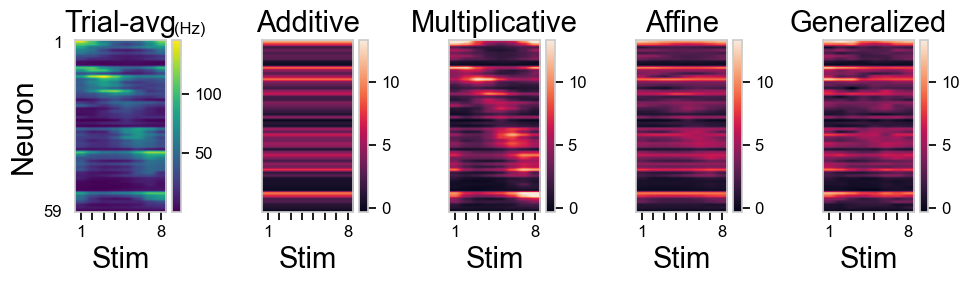

In [34]:
plot_shared_noise_coef(gen_model_V1.d_p, phi_V1, tuning_order_V1)
#plt.savefig('2023_fig/utah_array_stats_model/dataset4_phi_V1_revised.pdf', transparent='True')

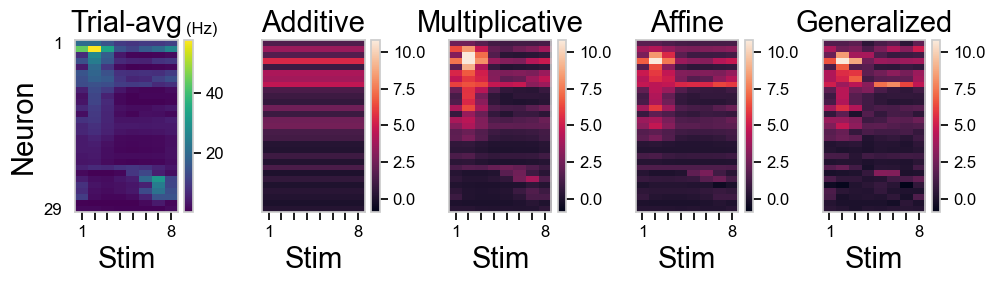

In [35]:
plot_shared_noise_coef(gen_model_V2.d_p, phi_V2, tuning_order_V2)
#plt.savefig('2023_fig/utah_array_stats_model/dataset4_phi_V2_revised.pdf', transparent='True')

## Visualize the variance of private variability from the fitted statistical models

In [30]:
def plot_private_noise(d, psi_add_varp, psi_mul, psi_aff, psi_gen, tuning_order, title):
    n = len(tuning_order)
    
    plt.figure(figsize=(14,3.5))
    plt.suptitle(title)
    plt.subplot(151)
    plt.imshow(d[tuning_order,:], aspect='auto', cmap='viridis', vmin=0, vmax=np.max(d))
    plt.title('Trial-avg',fontsize=MEDIUM_SIZE)
    plt.ylabel('Neuron',fontsize=MEDIUM_SIZE)
    plt.xlabel('Stim',fontsize=MEDIUM_SIZE)
    plt.yticks([0, n-1],[1,n])
    plt.xticks(range(8),[1] + [" "]*6 + [8])
    plt.tick_params(bottom=True)
    cbar = plt.colorbar()
    
    bbox = cbar.ax.get_position()
    plt.text(bbox.x0 + bbox.width / 2, 1.02, '(Hz)', transform=cbar.ax.transAxes, va='bottom', ha='left')

    plt.subplot(152)
    plt.imshow((psi_add_varp).detach().cpu().numpy()[tuning_order,:], aspect='auto', vmin=0, vmax=np.max(psi_gen), cmap='plasma')
    plt.title('Additive')
    plt.xlabel('Stim',fontsize=MEDIUM_SIZE)
    plt.xticks(range(8),[1] + [" "]*6 + [8])
    plt.yticks([0],[' '])
    plt.tick_params(bottom=True)
    plt.colorbar()
    
    plt.subplot(153)
    plt.imshow((psi_add_varp).detach().cpu().numpy()[tuning_order,:], aspect='auto', vmin=0, vmax=np.max(psi_gen), cmap='plasma')
    plt.title('Multiplicative')
    plt.xlabel('Stim',fontsize=MEDIUM_SIZE)
    plt.xticks(range(8),[1] + [" "]*6 + [8])
    plt.yticks([0],[' '])
    plt.tick_params(bottom=True)
    plt.colorbar()

    plt.subplot(154)
    plt.imshow((psi_mul).detach().cpu().numpy()[tuning_order,:], aspect='auto', vmin=0, vmax=np.max(psi_gen), cmap='plasma')
    plt.title('Affine')
    plt.xlabel('Stim',fontsize=MEDIUM_SIZE)
    plt.xticks(range(8),[1] + [" "]*6 + [8])
    plt.yticks([0],[' '])
    plt.tick_params(bottom=True)
    plt.colorbar()

    plt.subplot(155)
    plt.imshow(psi_gen[tuning_order,:], aspect='auto', vmin=0, vmax=np.max(psi_gen), cmap='plasma')
    plt.title('Generalized')
    plt.xlabel('Stim',fontsize=MEDIUM_SIZE)
    plt.xticks(range(8),[1] + [" "]*6 + [8])
    plt.yticks([0],[' '])
    plt.tick_params(bottom=True)
    plt.colorbar()
    plt.tight_layout()

In [31]:
plot_private_noise(gen_model_V2_all[0].d_p, add_varp_model_V2_all[0].psi_p, mul_model_V2_all[0].psi_p, aff_model_V2_all[0].psi_p, gen_model_V2_all[0].psi_p, tuning_order_V2,'The variance of private variability in V2')

#plt.savefig('2023_fig/utah_array_stats_model/dataset1_comp1_private_noise_V2_revised.pdf', transparent=True)

<IPython.core.display.Javascript object>

In [32]:
plot_private_noise(gen_model_V1_all[0].d_p, add_varp_model_V1_all[0].psi_p, mul_model_V1_all[0].psi_p, aff_model_V1_all[0].psi_p, gen_model_V1_all[0].psi_p, tuning_order_V1,'The variance of private variability in V1')

#plt.savefig('2023_fig/utah_array_stats_model/dataset1_comp1_private_noise_V1_revised.pdf', transparent=True)

<IPython.core.display.Javascript object>